In [2]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta, timezone
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import requests
import json
import csv
import pytz


/home/carl/MY_WORK/my_work/lib/python3.10/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  from scipy.stats import gaussian_kde


## 合併 2018 & 2019 的用電資料

In [3]:
# Read data for 2018 and 2019
file_2018 = './Origin/Building_energy_consumption/2018Floor6.csv'
file_2019 = './Origin/Building_energy_consumption/2019Floor6.csv'
df_2018 = pd.read_csv(file_2018)
df_2019 = pd.read_csv(file_2019) 

# Ensure timestamp is of datetime type
df_2018['Date'] = pd.to_datetime(df_2018['Date'], errors='coerce')
df_2019['Date'] = pd.to_datetime(df_2019['Date'], errors='coerce')

# Merge data for 2018 and 2019
df_merged = pd.concat([df_2018, df_2019], ignore_index=True)

# Save merged data to a new CSV file
output_file = './Sort/Building_energy_consumption/merged_Floor6.csv'
df_merged.to_csv(output_file, index=False, date_format='%Y-%m-%d %H:%M:%S')
print(f"Merging complete. Result saved to '{output_file}'")

Merging complete. Result saved to './Sort/Building_energy_consumption/merged_Floor6.csv'


## 將合併的用電資料中"非計算功率"的欄位過濾掉

In [4]:
# read data for 2018 and 2019
for i in range(1, 8):
    file_path = f'./Sort/Building_energy_consumption/merged_Floor{i}.csv'
    data = pd.read_csv(file_path)

    # choose columns with 'kW' in the name
    filtered_columns = [col for col in data.columns if '(kW)' in col or col == 'Date']
    filtered_data = data[filtered_columns]

    # store the filtered data in a new CSV file
    output_file_path = f'./Sort/Building_energy_consumption/filtered_merged_data_Floor{i}.csv'
    filtered_data.to_csv(output_file_path, index=False)

    # print the path of the saved file
    print(f"Filtered data saved to {output_file_path}")


Filtered data saved to ./Sort/Building_energy_consumption/filtered_merged_data_Floor1.csv
Filtered data saved to ./Sort/Building_energy_consumption/filtered_merged_data_Floor2.csv
Filtered data saved to ./Sort/Building_energy_consumption/filtered_merged_data_Floor3.csv
Filtered data saved to ./Sort/Building_energy_consumption/filtered_merged_data_Floor4.csv
Filtered data saved to ./Sort/Building_energy_consumption/filtered_merged_data_Floor5.csv
Filtered data saved to ./Sort/Building_energy_consumption/filtered_merged_data_Floor6.csv
Filtered data saved to ./Sort/Building_energy_consumption/filtered_merged_data_Floor7.csv


## 計算建物總用電量

In [54]:
# Specify the directory of CSV files
origin_directory = './Sort/Building_energy_consumption/'
output_directory = './BuildingEnergyLoad/'

# Get the paths of all CSV files
csv_files = glob.glob(os.path.join(origin_directory, 'filled*.csv'))

# Initialize a list to store all read dataframes
dataframes = []

# Iterate through all CSV files and append their data to the dataframes list
for file in csv_files:
    df = pd.read_csv(file)
    # Ensure that the timestamp is of datetime type, using errors='coerce' to handle invalid data
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Check and remove rows containing invalid date and time
    df = df.dropna(subset=['Date'])
    # Add a column indicating the source file
    df['Source_File'] = file
    dataframes.append(df)
    
print(f"Read {len(dataframes)} CSV files")
# Merge all dataframes using pd.concat()
combined_df = pd.concat(dataframes, ignore_index=True)

# Set the timestamp as the index
combined_df.set_index('Date', inplace=True)

# Calculate the total power consumption (sum of all power columns)
power_columns = [col for col in combined_df.columns if 'kW' in col]
combined_df[power_columns] = combined_df[power_columns].fillna(0)
combined_df['Total_Power(kWh)'] = combined_df[power_columns].sum(axis=1)

# Calculate the total power consumption in kWh
hourly_usage = combined_df['Total_Power(kWh)'].resample('H').sum() / 60

# Fill missing values (using the average of the previous and next values)
hourly_usage = hourly_usage.interpolate(method='linear')

# Round the values to two decimal places
hourly_usage = hourly_usage.round(2)

# Reset the index to save to CSV
hourly_usage = hourly_usage.reset_index()

# Save the result to a new CSV file
output_file = output_directory + 'BuildingConsumptionLoad.csv'
hourly_usage.to_csv(output_file, index=False, date_format='%Y-%m-%d %H:%M:%S')

print(f"Sorting completed, the result has been saved to '{output_file}'")

Read 7 CSV files


/tmp/ipykernel_2372408/1615101145.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_usage = combined_df['Total_Power(kWh)'].resample('H').sum() / 60


Sorting completed, the result has been saved to './BuildingEnergyLoad/BuildingConsumptionLoad.csv'


## 建物負載資料呈現

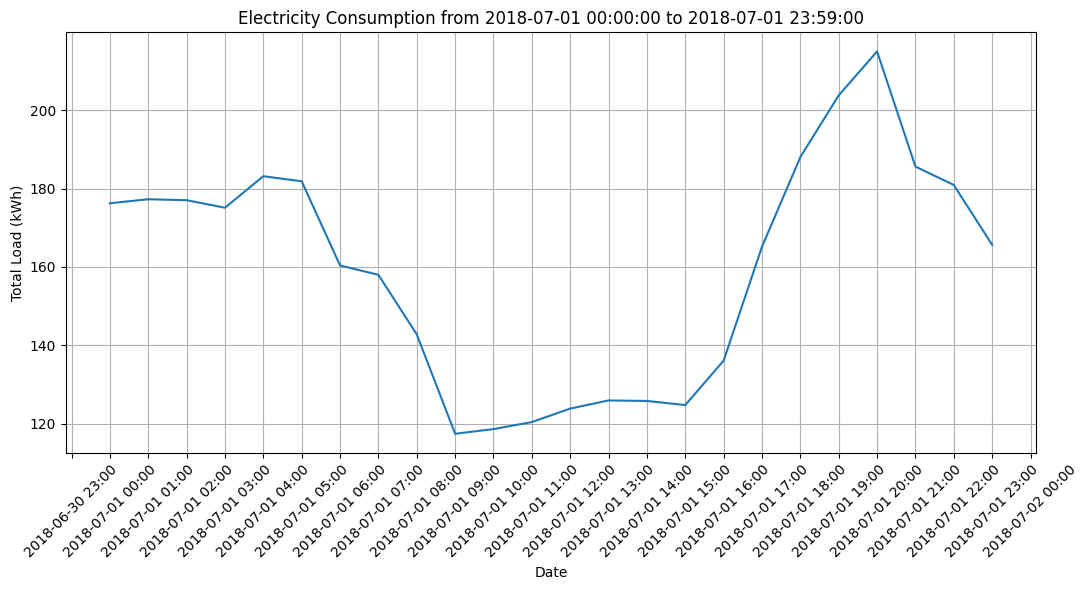

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# set the start and end time
start_time = '2018-07-01 00:00:00'
end_time = '2018-07-01 23:59:00'

# read the data
BuildingConsumptionLoad = pd.read_csv('./Dataset/BuildingEnergyLoad/BuildingConsumptionLoad.csv')

# convert the 'Date' column to datetime type
BuildingConsumptionLoad['Date'] = pd.to_datetime(BuildingConsumptionLoad['Date'])

# filter the data based on the start and end time
filtered_data = BuildingConsumptionLoad[(BuildingConsumptionLoad['Date'] >= start_time) & (BuildingConsumptionLoad['Date'] <= end_time)]

# plot the data
plt.figure(figsize=(11, 6))
plt.plot(filtered_data['Date'], filtered_data['Total_Power(kWh)'])
plt.xlabel('Date')
plt.ylabel('Total Load (kWh)')
plt.title(f'Electricity Consumption from {start_time} to {end_time}')

# calculate the time range
time_range = pd.to_datetime(end_time) - pd.to_datetime(start_time)

# set the x-axis labels based on the time range
if time_range <= pd.Timedelta(days=2):
    # if the range is less than or equal to 2 days, show the time every hour
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
elif time_range <= pd.Timedelta(days=7):
    # if the range is less than or equal to 7 days, show the time every 3 hours
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
elif time_range <= pd.Timedelta(days=30):
    # if the range is less than or equal to 30 days, show the time every 3 days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
else:
    # if the range is greater than 30 days, show the time every week
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

# rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 模擬 EV User 停車資料

In [6]:
def generate_ev_data(start_date, end_date, num_agents):
    np.random.seed(42)
    date_range = pd.date_range(start_date, end_date, freq='D')
    ev_request_data = []

    for single_date in date_range:
        base_date = single_date.replace(hour=0, minute=0, second=0, microsecond=0)
        arrival_times = [base_date + timedelta(hours=int(np.random.uniform(7, 12))) for _ in range(num_agents)]
        departure_times = [base_date + timedelta(hours=int(np.random.uniform(16, 23))) for _ in range(num_agents)]
        initial_socs = np.round(np.random.uniform(0.3, 0.6, num_agents), 2)
        departure_socs = np.round(np.random.uniform(0.6, 0.9, num_agents), 2)

        for i in range(num_agents):
            # Generate a unique request ID combining the date and the car index
            request_id = single_date.strftime('%Y%m%d') + f'{i+1:03d}'
            ev_request_data.append({
                'requestID': request_id,  # Generate a unique request ID
                'arrival_time': arrival_times[i],  # Generate a random arrival time
                'departure_time': departure_times[i],  # Generate a random departure time
                'initial_soc': initial_socs[i],  # Generate a random initial SoC
                'departure_soc': departure_socs[i],  # Generate a random departure SoC
                'date': single_date.strftime('%Y-%m-%d')  # Add date for filtering
            })
    
    ev_request_df = pd.DataFrame(ev_request_data)
    ev_request_df.to_csv(f'./Dataset/Sim_Parking/ev_parking_data_from_{start_date}_to_{end_date}_{num_agents}.csv', index=False)
    print(f"EV parking data generated and saved to ev_parking_data_from_{start_date}_to_{end_date}_{num_agents}.csv")

In [9]:
start_date = '2018-07-01'
end_date = '2018-12-31'
num_agents = 10
generate_ev_data(start_date, end_date, num_agents)

EV parking data generated and saved to ev_parking_data_from_2018-07-01_to_2018-12-31_10.csv


## Real-Time-Price (RTP)

In [29]:
datestart = DATASTART = 201807010000
dateend = DATAEND = 201812312359

def fetch_data(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return []

def save_to_csv(data, file_name):
    hourly_data = defaultdict(list)
    
    for entry in data:
        millisUTC = int(entry["millisUTC"])
        price = float(entry["price"]) / 100
        dt = datetime.utcfromtimestamp(millisUTC / 1000.0)
        dt_utc_minus_5 = dt - timedelta(hours=5)
        hour = dt_utc_minus_5.replace(minute=0, second=0, microsecond=0)
        hourly_data[hour].append(price)

    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["datetime", "average_price"])
        
        for hour in sorted(hourly_data):
            avg_price = sum(hourly_data[hour]) / len(hourly_data[hour])
            writer.writerow([hour, avg_price])

def main():
    api_url = f'https://hourlypricing.comed.com/api?type=5minutefeed&datestart={datestart}&dateend={dateend}'  # Replace with your API endpoint
    data = fetch_data(api_url)
    if data:
        save_to_csv(data, f'./RTP/electricity_prices_from_{DATASTART}_to_{DATAEND}.csv')
        print(f"Data saved to electricity_prices_from_{DATASTART}_to_{DATAEND}.csv")

if __name__ == '__main__':
    main()

Data saved to electricity_prices_from_201807010000_to_201812312359.csv


In [3]:
def visualize_data(electricity_prices, start_time, end_time):
    mask = (electricity_prices['datetime'] >= start_time) & (electricity_prices['datetime'] <= end_time)
    filtered_data = electricity_prices[mask]

    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['datetime'], filtered_data['average_price'], label='Average Price')
    plt.xlabel('Datetime (UTC)')
    plt.ylabel('Average Price (USD)')
    plt.title('Electricity Prices Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

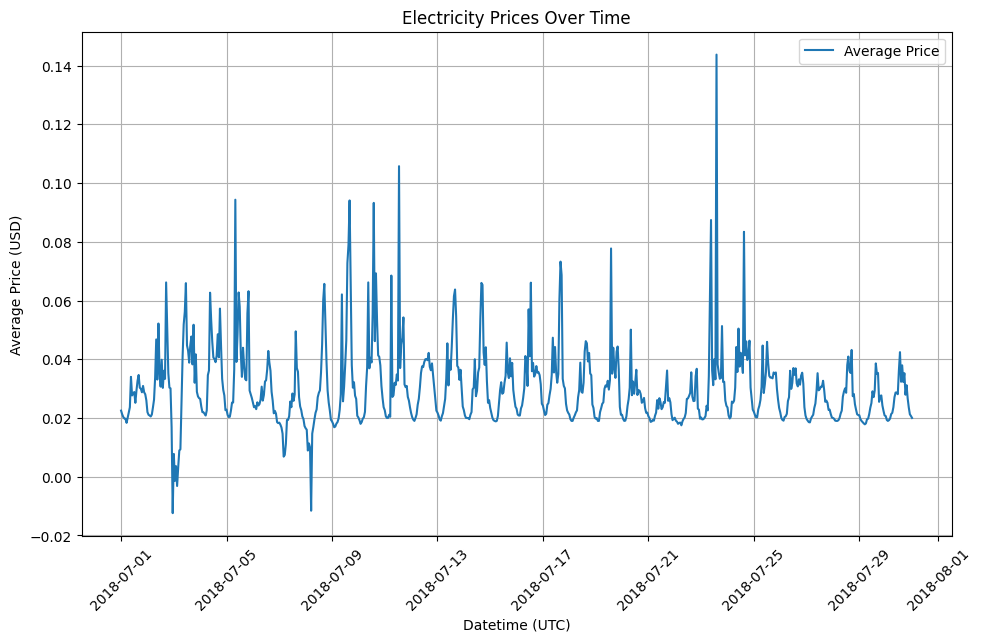

In [4]:
electricity_prices = pd.read_csv('./Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv')
electricity_prices['datetime'] = pd.to_datetime(electricity_prices['datetime'])

# Define the start and end time for visualization
start_time = datetime(2018, 7, 1)
end_time = datetime(2018, 7, 31)

# Visualize the data
visualize_data(electricity_prices, start_time, end_time)